# Step 0a: Dataset retrieval


If token is not manually uploaded in the first place...
```
from google.colab import files
files.upload() #upload kaggle.json
```

Install Kaggle, auth, then download dataset
```
# Install Kaggle from PyPI
!pip install -q kaggle

# Kaggle: auth
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d crawford/emnist

# Dataset: extract balanced only
!unzip emnist.zip emnist-balanced-test.csv
!unzip emnist.zip emnist-balanced-train.csv
!unzip emnist.zip emnist-balanced-mapping.txt
```

# Step 0b: Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization,Activation,Input
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils
import sklearn.metrics as metrics

import itertools

# Step 1: Dataset reading

In [2]:
"""
Read dataset
"""

train = pd.read_csv("emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [3]:
"""
Split dataset into train + test set
"""

train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [4]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


# Step 2: Preprocessing

In [5]:
"""
Correct image orientations and normalize them
"""


HEIGHT = 28
WIDTH = 28
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


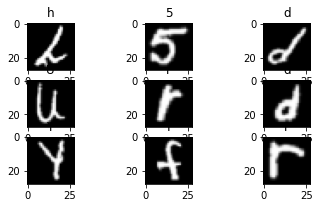

In [6]:
"""
Show sample images from the train set to verify
"""

for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))

In [7]:
# number of classes
num_classes = train_y.nunique()
print(num_classes)

47


In [8]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [9]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [10]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

# Step 3: Model building

In [11]:
    model = Sequential([
        
    # Layer 1
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (HEIGHT,WIDTH,1), kernel_regularizer=l2(0.0005), name = 'convolution_1'),
    
    # Layer 2
    Conv2D(filters = 32, kernel_size = 5, strides = 1, name = 'convolution_2', use_bias=False),
    
    # Layer 3    
    BatchNormalization(name = 'batchnorm_1'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),
    Dropout(0.25, name = 'dropout_1'),
    # -------------------------------- #  
        
    # Layer 3
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005), name = 'convolution_3'),
        
    # Layer 4
    Conv2D(filters = 64, kernel_size = 3, strides = 1, name = 'convolution_4', use_bias=False),
        
    # Layer 5
    BatchNormalization(name = 'batchnorm_2'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),
    Dropout(0.25, name = 'dropout_2'),
    Flatten(name = 'flatten'),
    # -------------------------------- #  
        
    # Layer 6
    Dense(units = 256, name = 'fully_connected_1', use_bias=False),
        
    # Layer 7
    BatchNormalization(name = 'batchnorm_3'),
    
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 8
    Dense(units = 128, name = 'fully_connected_2', use_bias=False),
        
    # Layer 9
    BatchNormalization(name = 'batchnorm_4'),
        
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 10
    Dense(units = 84, name = 'fully_connected_3', use_bias=False),
        
    # Layer 11
    BatchNormalization(name = 'batchnorm_5'),
        
    # -------------------------------- #  
    Activation("relu"),
    Dropout(0.25, name = 'dropout_3'),
    # -------------------------------- #  

    # Output
    Dense(units = num_classes, activation = 'softmax', name = 'output')
        
    ])
    
    model._name = 'LeNet5v2'
model.summary()

Model: "LeNet5v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution_1 (Conv2D)       (None, 24, 24, 32)        832       
_________________________________________________________________
convolution_2 (Conv2D)       (None, 20, 20, 32)        25600     
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 20, 20, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 20, 20, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
convolution_3 (Conv2D)       (None, 8, 8, 64)          184

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Training

In [13]:
history = model.fit(train_x, train_y, epochs=15, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

Epoch 1/15
199/199 [==============================] - 8s 42ms/step - loss: 1.6956 - accuracy: 0.5718 - val_loss: 4.3788 - val_accuracy: 0.0447
Epoch 2/15
199/199 [==============================] - 8s 39ms/step - loss: 0.5982 - accuracy: 0.8166 - val_loss: 1.6269 - val_accuracy: 0.5161
Epoch 3/15
199/199 [==============================] - 8s 38ms/step - loss: 0.4805 - accuracy: 0.8446 - val_loss: 0.4489 - val_accuracy: 0.8498
Epoch 4/15
199/199 [==============================] - 8s 38ms/step - loss: 0.4293 - accuracy: 0.8580 - val_loss: 0.3807 - val_accuracy: 0.8639
Epoch 5/15
199/199 [==============================] - 8s 38ms/step - loss: 0.4004 - accuracy: 0.8660 - val_loss: 0.3382 - val_accuracy: 0.8809
Epoch 6/15
199/199 [==============================] - 8s 39ms/step - loss: 0.3801 - accuracy: 0.8698 - val_loss: 0.3395 - val_accuracy: 0.8797
Epoch 7/15
199/199 [==============================] - 8s 39ms/step - loss: 0.3642 - accuracy: 0.8764 - val_loss: 0.3710 - val_accuracy: 0.8699

In [14]:
model.save('LeNet5v2.h5')

In [15]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [16]:
#%%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

In [17]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.33752888441085815
Test accuracy: 0.8855258226394653


# Step 5: Assessment

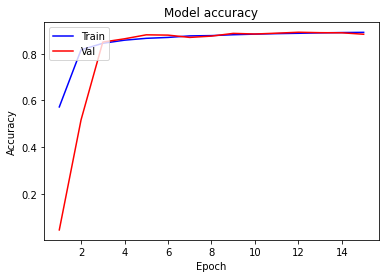

In [18]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

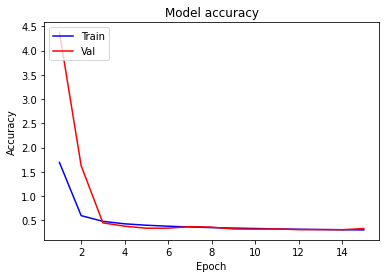

In [19]:
# loss curve
plotgraph(epochs, loss, val_loss)

In [20]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

In [21]:
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


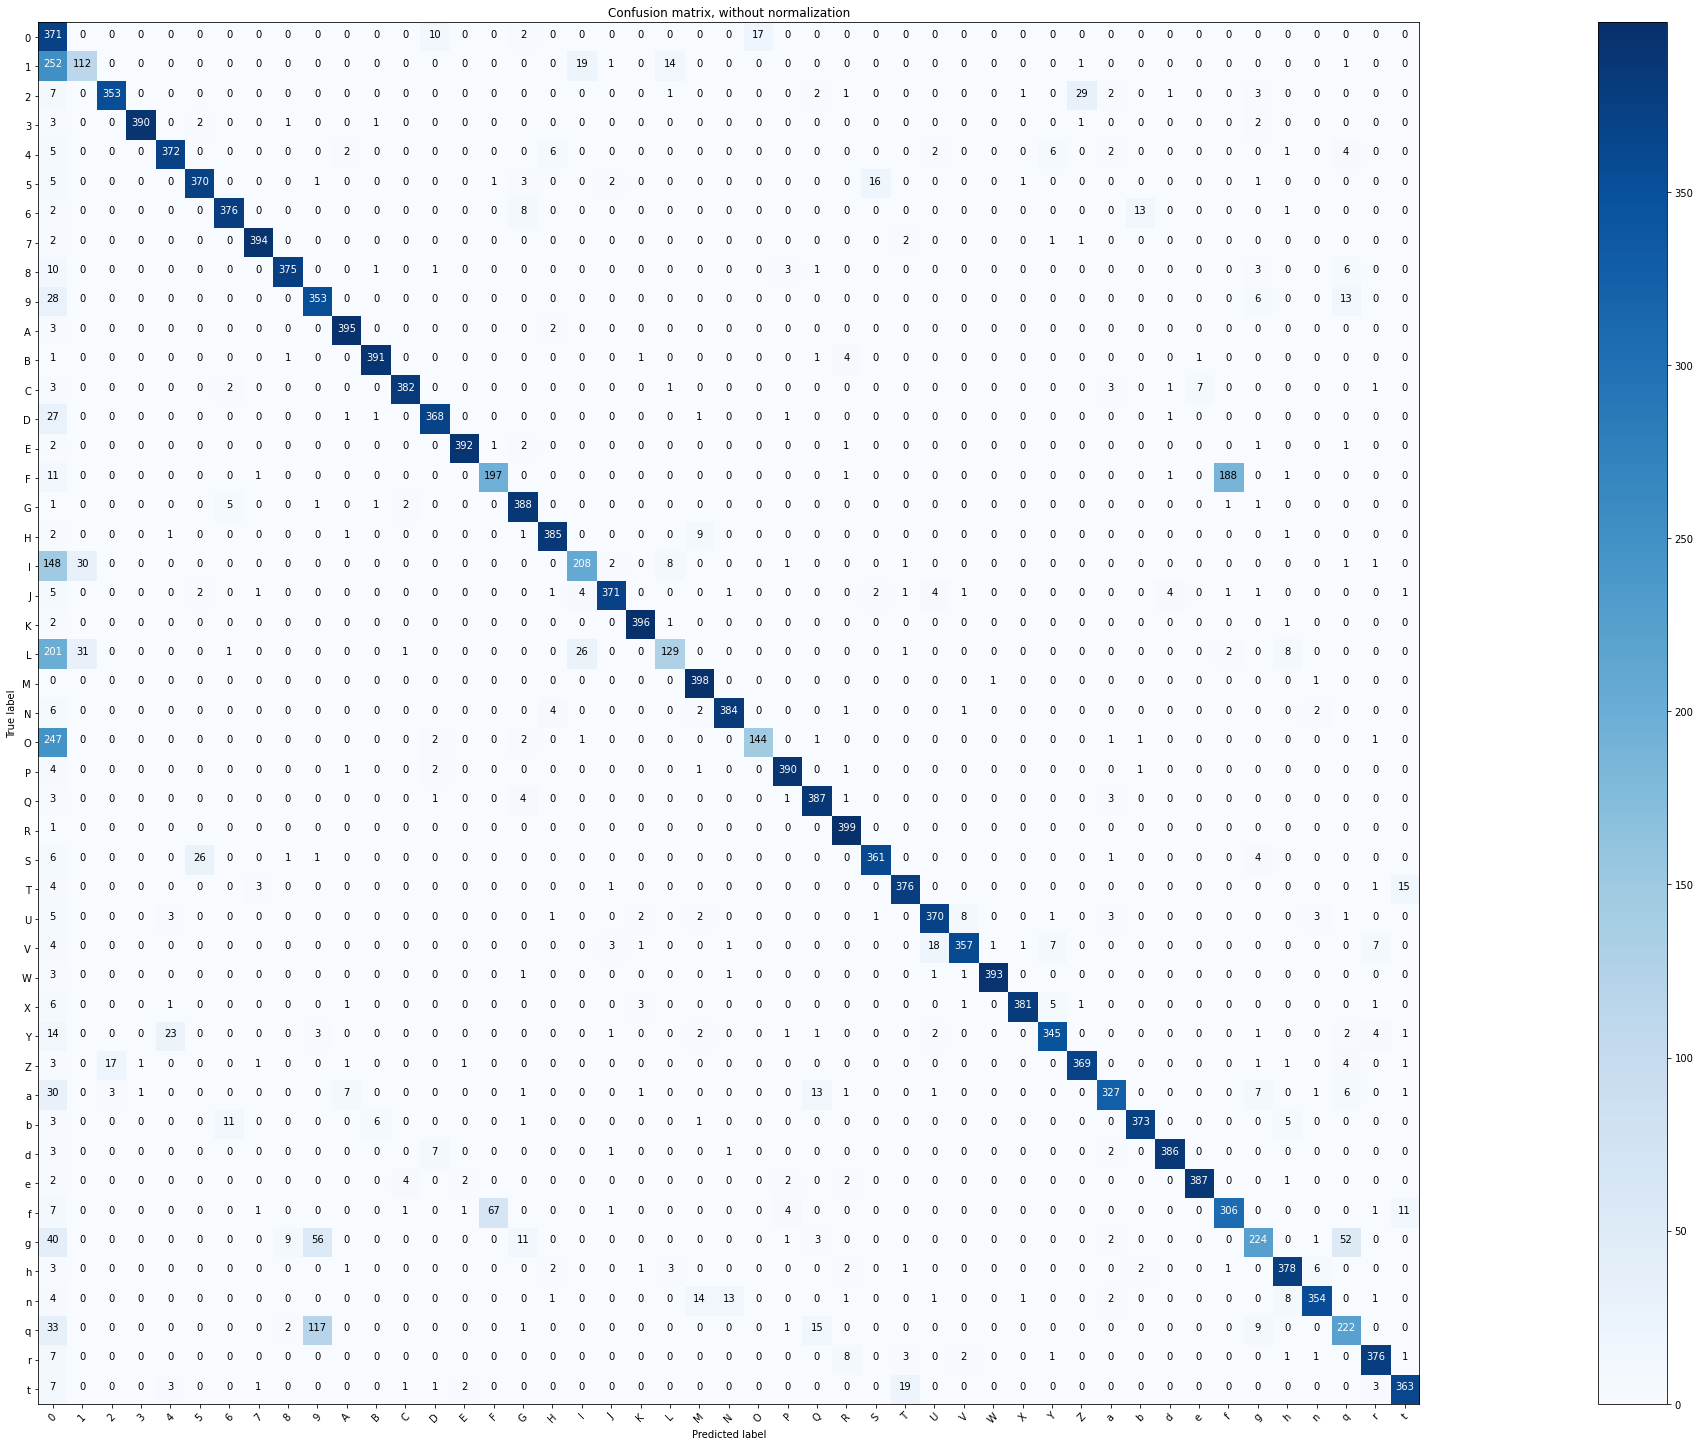

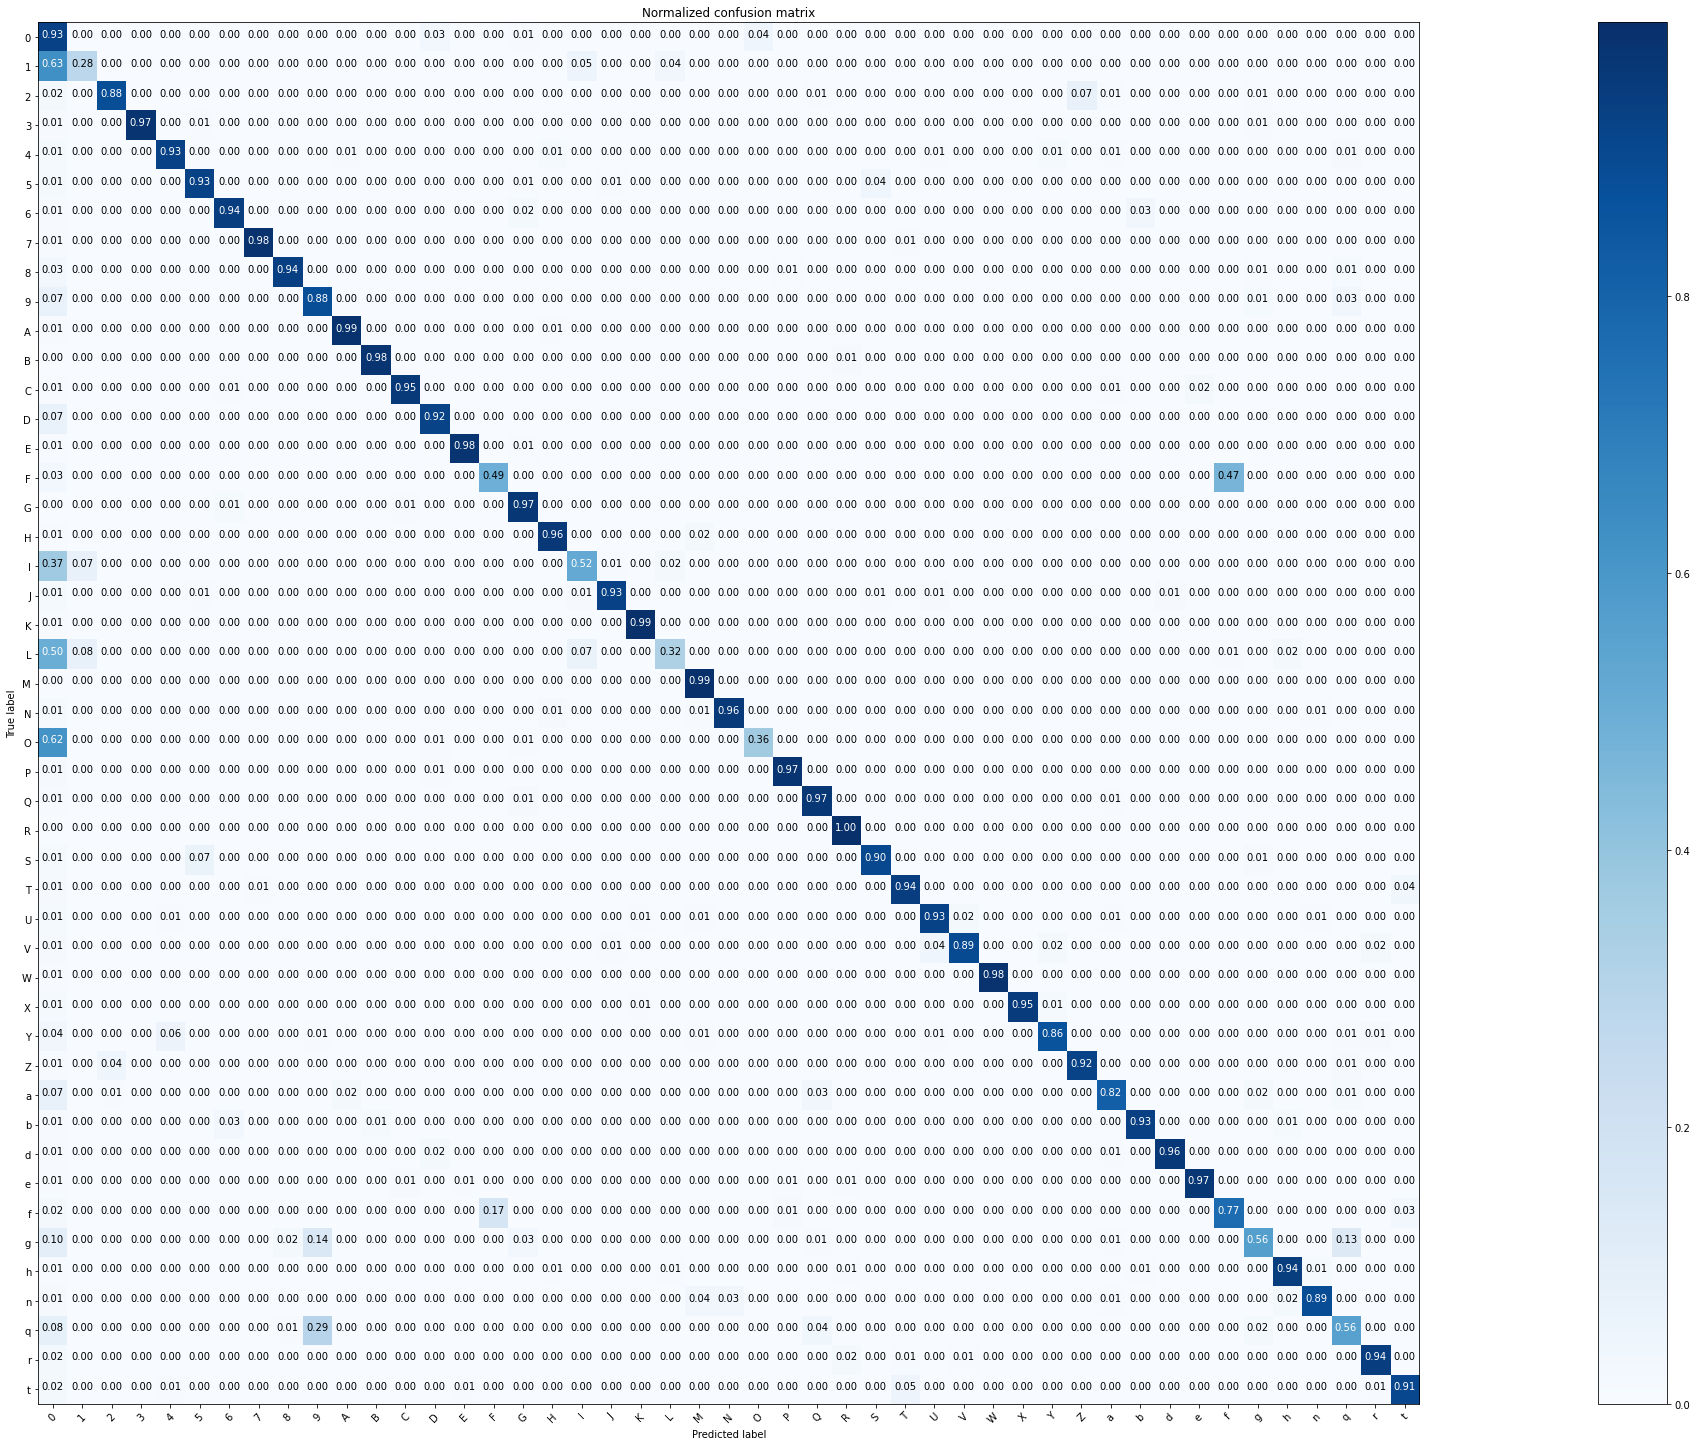

In [23]:
class_names = [chr(mapp[i]) for i in range(num_classes)]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(50,20))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(50,20))
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

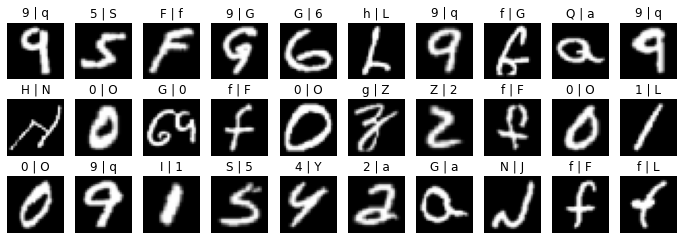

In [24]:
"""
Draw incorrect predictions
"""

f = plt.figure(figsize=(12,4))
n = -1
for i in range(test_y.shape[0]):
  if (test_y[i] != y_pred[i]).any() and n < 29 and np.count_nonzero(y_pred[i]) != 0:
    n += 1
    sp = f.add_subplot(3, 10, n+1)
    sp.axis('Off')
    sp.set_title(chr(mapp[np.where(y_pred[i]==True)[0][0]]) + " | " +  chr(mapp[np.where(test_y[i] == True)[0][0]]))
    plt.imshow(test_x[i].reshape((28,28)), cmap=plt.get_cmap('gray'))
    if n == 30:
      print(i)
      f = plt.figure(figsize=(12,4))
      break

Save wrong predicted image.
```python
"""
Save wrong predicted image.
"""
import keras
from PIL import Image, ImageOps
import os

def save_image(filename, data_array):
    im = Image.fromarray(data_array.astype('uint8'))
    im_invert = ImageOps.invert(im)
    im_invert.save(filename)

DIR_NAME = "JPEGImages"
if os.path.exists(DIR_NAME) == False:
    os.mkdir(DIR_NAME)

# Save Images
i = 0
for i in range(test_y.shape[0]):
  if (test_y[i] != y_pred[i]).any() and np.count_nonzero(y_pred[i]) != 0:
    print("[---------------------------------------------------------------]")
    if os.path.exists(f'{DIR_NAME}/{chr(mapp[np.where(test_y[i] == True)[0][0]])}') == False:
      os.mkdir(f'{DIR_NAME}/{chr(mapp[np.where(test_y[i] == True)[0][0]])}')
    filename = "{0}/{3}/{1:05d}_{2}.jpg".format(DIR_NAME,i,chr(mapp[np.where(y_pred[i]==True)[0][0]]),chr(mapp[np.where(test_y[i] == True)[0][0]]))
    print(filename)
    save_image(filename, test_x[i].reshape((28,28))*255)
    i += 1
```
Zip it
```
!zip -r wrong_pred.zip JPEGImages 
```
Download it
```bash
from google.colab import files
files.download("/content/wrong_pred.zip")
```
